> __Purpose:__ This NB visualizes the results of the full study for DynamicMomonaNet. Will be adding different feature engineerings here.

In [ ]:
import numpy as np
#from sklearn.preprocessing import LabelEncoder
#import matplotlib.pyplot as plt
#import pandas as pd

np.random.seed(42) 

from agglo_model_clust import *
from cluster_acc_viz_funcs import *
from DNN_FT_funcs import *
from DNN_AMC_funcs import *
from full_study_funcs import *  # Replace?
from revamped_model_classes import *
from hyperparam_tuned_configs import *

import os
cwd = os.getcwd()
print("Current Working Directory: ", cwd)


Current Working Directory:  c:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj


In [ ]:
MODEL_STR = "DynamicMomonaNet"
MY_CONFIG = DynamicMomonaNet_config
NUM_MONTE_CARLO_RUNS = 10
SAVE_FIGS = False
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Train/test user split: 24/8
## Is this part of config now? The split number?
## No it is hardcoded below...
NUM_PRETRAIN_USERS = 24
NUM_FT_USERS = 8



In [3]:
expdef_df = load_expdef_gestures(feateng_method=MY_CONFIG["feature_engr"])

print(expdef_df.shape)
expdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P102,pan,1,"[[-1.5563754649803136, -0.17884213655174025, -...",5,6
1,P102,pan,2,"[[-2.0947934429427453, -0.18463052523258242, -...",5,6
2,P102,pan,3,"[[-1.47972105766918, -0.14489860670069354, -0....",5,6
3,P102,pan,4,"[[-1.4504054170702374, -0.18478424991674858, -...",5,6
4,P102,pan,5,"[[-1.809093742221055, -0.21738573258562152, -0...",5,6


In [4]:
# Load the CLUSTERING RESULTS DATA
with open('C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\results\\clustering_models\\20250210_2137\\20250210_2137_DynamicMomonaNet_agglo_merge_res.pkl', 'rb') as f:
    merge_log = pickle.load(f)
    intra_cluster_performance = pickle.load(f)
    cross_cluster_performance = pickle.load(f)
    nested_clus_model_dict = pickle.load(f)

print("Data has been loaded successfully!")

Data has been loaded successfully!


In [5]:
full_path = os.path.join("C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\models\\20250211_2010", 'pretrained_DynamicMomonaNet_model.pth')

print("Full Path:", full_path)
# Load the pretrained model
pretrained_generic_model = select_model(MODEL_STR, MY_CONFIG)
pretrained_generic_model.load_state_dict(torch.load(full_path))

Full Path: C:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj\models\20250211_2010\pretrained_DynamicMomonaNet_model.pth


<All keys matched successfully>

In [ ]:
import json
# Load the fixed user splits
with open("24_8_user_splits.json", "r") as f:
    splits = json.load(f)
all_participants = splits["all_users"]
test_participants = splits["test_users"]


## ONE-SHOT: 1 trial for training (local+FT) and cluster assignment

In [ ]:
lst_of_res_dicts_oneshot = [0]*NUM_MONTE_CARLO_RUNS
for i in range(NUM_MONTE_CARLO_RUNS):

    # Prepare data
    ## Unknown determenism / stochasticity...
    ## Some randomness from the 8/2 and 3/7 splits, namely which gestures get included...
    data_splits = prepare_data(
        expdef_df, 'feature', 'Gesture_Encoded', 
        all_participants, test_participants, 
        training_trials_per_gesture=8, finetuning_trials_per_gesture=3,
    )

    # Fit LabelEncoder once on all participant IDs for consistency
    all_participant_ids = data_splits['train']['participant_ids'] + data_splits['intra_subject_test']['participant_ids']
    label_encoder = LabelEncoder()
    label_encoder.fit(all_participant_ids)

    # Process train and test sets
    train_df = process_split(data_splits, 'train', label_encoder)
    test_df = process_split(data_splits, 'intra_subject_test', label_encoder)
    data_dfs_dict = {'train':train_df, 'test':test_df}

    # Prepare data
    one_trial_data_splits = prepare_data(
        expdef_df, 'feature', 'Gesture_Encoded', 
        all_participants, test_participants, 
        training_trials_per_gesture=1, finetuning_trials_per_gesture=1,
    )
    #five_trial_data_splits = prepare_data(
    #    expdef_df, 'feature', 'Gesture_Encoded', 
    #    all_participants, test_participants, 
    #    training_trials_per_gesture=5, finetuning_trials_per_gesture=5,
    #)

    # data_dict_1_1
    lst_of_res_dicts_oneshot[i] = full_comparison_run(one_trial_data_splits, one_trial_data_splits, MY_CONFIG, pretrained_generic_model,
                            nested_clus_model_dict, MODEL_STR, cluster_iter_str='Iter18')


PID P010, 1/8
Epoch 00006: reducing learning rate of group 0 to 1.0000e-03.
Cluster 38 had the highest accuracy (0.3)
PID P102, 2/8
Epoch 00031: reducing learning rate of group 0 to 1.0000e-03.
Cluster 38 had the highest accuracy (0.7)
Epoch 00011: reducing learning rate of group 0 to 1.0000e-03.
PID P104, 3/8
Epoch 00014: reducing learning rate of group 0 to 1.0000e-03.
Cluster 38 had the highest accuracy (0.2)
PID P108, 4/8
Cluster 40 had the highest accuracy (0.7)
Epoch 00010: reducing learning rate of group 0 to 1.0000e-03.
PID P121, 5/8
Epoch 00006: reducing learning rate of group 0 to 1.0000e-03.
Cluster 31 had the highest accuracy (0.1)
Epoch 00006: reducing learning rate of group 0 to 1.0000e-03.
PID P123, 6/8
Epoch 00006: reducing learning rate of group 0 to 1.0000e-03.
Cluster 39 had the highest accuracy (0.2)
Epoch 00023: reducing learning rate of group 0 to 1.0000e-03.
PID P124, 7/8
Epoch 00006: reducing learning rate of group 0 to 1.0000e-03.
Cluster 35 had the highest acc

In [9]:
data_dict_1_1 = {}    
data_dict_1_1['local_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_1_1['centralized_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_1_1['ft_centralized_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_1_1['pretrained_cluster_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_1_1['ft_cluster_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)

for idx, res_dict in enumerate(lst_of_res_dicts_oneshot):
    data_dict_1_1['local_acc_data'] += np.array(res_dict['local_acc_data'])
    data_dict_1_1['centralized_acc_data'] += np.array(res_dict['centralized_acc_data'])
    data_dict_1_1['ft_centralized_acc_data'] += np.array(res_dict['ft_centralized_acc_data'])
    data_dict_1_1['pretrained_cluster_acc_data'] += np.array(res_dict['pretrained_cluster_acc_data'])
    data_dict_1_1['ft_cluster_acc_data'] += np.array(res_dict['ft_cluster_acc_data'])

data_dict_1_1['local_acc_data'] /= (idx+1)
data_dict_1_1['centralized_acc_data'] /= (idx+1)
data_dict_1_1['ft_centralized_acc_data'] /= (idx+1)
data_dict_1_1['pretrained_cluster_acc_data'] /= (idx+1)
data_dict_1_1['ft_cluster_acc_data'] /= (idx+1)

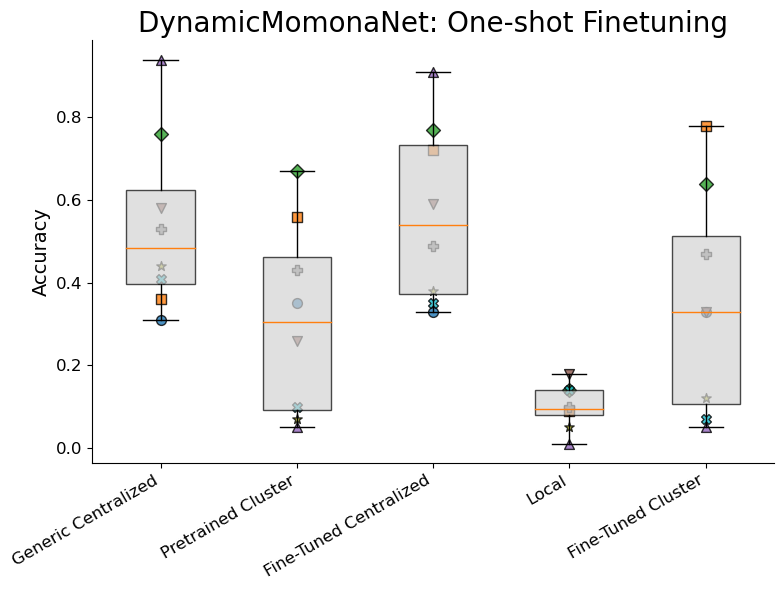

In [10]:
plot_model_acc_boxplots(data_dict_1_1, my_title=f"{MODEL_STR}: One-shot Finetuning", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_1TA_1TT")

## FEW-SHOT: 5 trials for training (local+FT) and 5 trials for cluster assignment

In [ ]:
lst_of_res_dicts_fiveshot = [0]*NUM_MONTE_CARLO_RUNS
for i in range(NUM_MONTE_CARLO_RUNS):

    # Prepare data
    ## Unknown determenism / stochasticity...
    ## Some randomness from the 8/2 and 3/7 splits, namely which gestures get included...
    data_splits = prepare_data(
        expdef_df, 'feature', 'Gesture_Encoded', 
        all_participants, test_participants, 
        training_trials_per_gesture=8, finetuning_trials_per_gesture=3,
    )

    # Fit LabelEncoder once on all participant IDs for consistency
    all_participant_ids = data_splits['train']['participant_ids'] + data_splits['intra_subject_test']['participant_ids']
    label_encoder = LabelEncoder()
    label_encoder.fit(all_participant_ids)

    # Process train and test sets
    train_df = process_split(data_splits, 'train', label_encoder)
    test_df = process_split(data_splits, 'intra_subject_test', label_encoder)
    data_dfs_dict = {'train':train_df, 'test':test_df}

    # Prepare data
    #one_trial_data_splits = prepare_data(
    #    expdef_df, 'feature', 'Gesture_Encoded', 
    #    all_participants, test_participants, 
    #    training_trials_per_gesture=1, finetuning_trials_per_gesture=1,
    #)
    five_trial_data_splits = prepare_data(
        expdef_df, 'feature', 'Gesture_Encoded', 
        all_participants, test_participants, 
        training_trials_per_gesture=5, finetuning_trials_per_gesture=5,
    )

    # data_dict_5_5
    lst_of_res_dicts_fiveshot[i] = full_comparison_run(five_trial_data_splits, five_trial_data_splits, MY_CONFIG, pretrained_generic_model,
                            nested_clus_model_dict, MODEL_STR, cluster_iter_str='Iter18')


PID P010, 1/8
Epoch 00017: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00028: reducing learning rate of group 0 to 1.0000e-04.
Cluster 39 had the highest accuracy (0.36)
Epoch 00017: reducing learning rate of group 0 to 1.0000e-03.
PID P102, 2/8
Epoch 00019: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.
Cluster 38 had the highest accuracy (0.7)
PID P104, 3/8
Epoch 00027: reducing learning rate of group 0 to 1.0000e-03.
Cluster 38 had the highest accuracy (0.2)
Epoch 00019: reducing learning rate of group 0 to 1.0000e-03.
PID P108, 4/8
Epoch 00006: reducing learning rate of group 0 to 1.0000e-03.
Cluster 40 had the highest accuracy (0.22)
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
PID P121, 5/8
Epoch 00027: reducing learning rate of group 0 to 1.0000e-03.
Cluster 31 had the highest accuracy (0.6)
PID P123, 6/8
Epoch 00025: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00033: reducing 

In [12]:
data_dict_5_5 = {}    
data_dict_5_5['local_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_5_5['centralized_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_5_5['ft_centralized_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_5_5['pretrained_cluster_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)
data_dict_5_5['ft_cluster_acc_data'] = np.zeros(NUM_FT_USERS, dtype=np.float32)

for idx, res_dict in enumerate(lst_of_res_dicts_fiveshot):
    data_dict_5_5['local_acc_data'] += np.array(res_dict['local_acc_data'])
    data_dict_5_5['centralized_acc_data'] += np.array(res_dict['centralized_acc_data'])
    data_dict_5_5['ft_centralized_acc_data'] += np.array(res_dict['ft_centralized_acc_data'])
    data_dict_5_5['pretrained_cluster_acc_data'] += np.array(res_dict['pretrained_cluster_acc_data'])
    data_dict_5_5['ft_cluster_acc_data'] += np.array(res_dict['ft_cluster_acc_data'])

data_dict_5_5['local_acc_data'] /= (idx+1)
data_dict_5_5['centralized_acc_data'] /= (idx+1)
data_dict_5_5['ft_centralized_acc_data'] /= (idx+1)
data_dict_5_5['pretrained_cluster_acc_data'] /= (idx+1)
data_dict_5_5['ft_cluster_acc_data'] /= (idx+1)

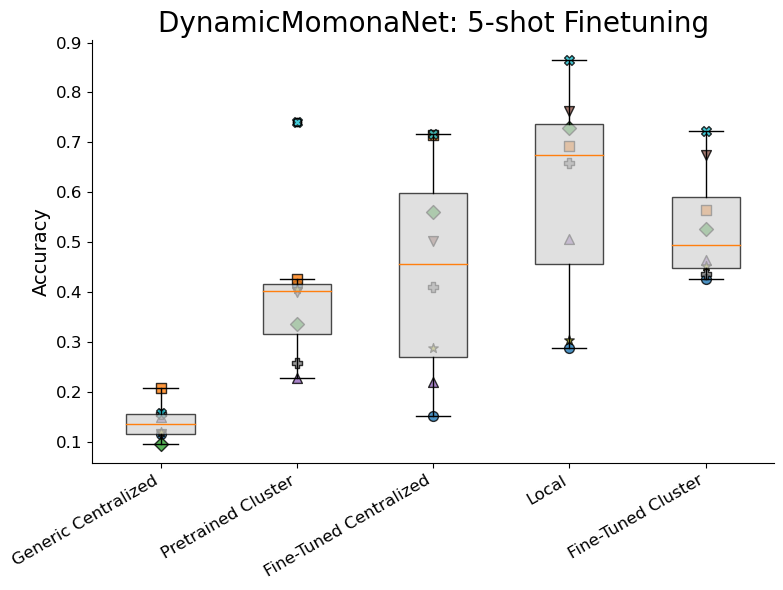

In [13]:
plot_model_acc_boxplots(data_dict_5_5, my_title=f"{MODEL_STR}: 5-shot Finetuning", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_5TA_5TT")
